In [211]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [212]:
!git clone https://github.com/sankalp-25/Unmixing_using_K_P_Means/

fatal: destination path 'Unmixing_using_K_P_Means' already exists and is not an empty directory.


In [213]:
!python --version

Python 3.9.16


In [214]:
import os
os.chdir('/content/Unmixing_using_K_P_Means/Datasets')

 # Search for 'change is to be done here' and uncomment the dataset you want to train 

 (Note that tensorflow builds a graph and sometimes when you utilize it for substraction, it gives out the object but not the value. So  if you want to run the program again making changes above training the autoencoder, make sure you disconnect and delete run time and run it again)

In [215]:
!pip install munkres
!pip install tensorflow
!pip install keras
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [216]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
import scipy.linalg as splin
import scipy.io as sioT
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score
from spectral import *
import time
from tensorflow.keras import initializers, constraints, layers, activations, regularizers

In [217]:
!python --version
print(tf. __version__) 
print(np. __version__) 

Python 3.9.16
2.12.0
1.22.4


In [218]:
from Unmixing_using_K_P_Means.utils.data import HSI
from Unmixing_using_K_P_Means.utils.metrics import SADDegrees as SADMetric
from Unmixing_using_K_P_Means.utils.metrics import SRE
from Unmixing_using_K_P_Means.utils.aligners import MunkresAbundancesAligner as Aligner
from Unmixing_using_K_P_Means.utils.noises import AdditiveWhiteGaussianNoise as AWGN
from Unmixing_using_K_P_Means.utils.metrics import MeanSquareError as MSE
from Unmixing_using_K_P_Means.utils.metrics import aRMSE as RMSE

In [219]:
import numpy as np
import scipy.io
import scipy.io as sio

datasets=["DC2","JasperRidge","Samson", "Sim1", "TinyAPEX"]

#  used to get the varibles in each and individual dataset
for i in datasets:
    k = "/content/Unmixing_using_K_P_Means/Datasets/"+ i + ".mat"
    mat_file = scipy.io.loadmat(k)
    var_names = [var for var in mat_file.keys() if not var.startswith("__")]
    print(f"Variables in {k}: {var_names}")




Variables in /content/Unmixing_using_K_P_Means/Datasets/DC2.mat: ['Y', 'E', 'A', 'H', 'W', 'p', 'L', 'labels']
Variables in /content/Unmixing_using_K_P_Means/Datasets/JasperRidge.mat: ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels']
Variables in /content/Unmixing_using_K_P_Means/Datasets/Samson.mat: ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels']
Variables in /content/Unmixing_using_K_P_Means/Datasets/Sim1.mat: ['Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels']
Variables in /content/Unmixing_using_K_P_Means/Datasets/TinyAPEX.mat: ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels']


In [220]:
#saving ground truths in form of .mat

datasets = {
    'DC2': ['Y', 'E', 'A', 'H', 'W', 'p', 'L', 'labels'],
    'JasperRidge': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'],
    'Samson': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'],
    'Sim1': ['Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels'],
    'TinyAPEX': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels']
}

# Iterate over each dataset
for dataset_name, dataset_vars in datasets.items():
    # Load the dataset
    dataset = sio.loadmat(dataset_name + '.mat')
    
    # Extract the labels
    labels = dataset[dataset_vars[-1]].flatten()
    
    # Create a ground truth matrix using the labels
    ground_truth = np.zeros((len(labels), len(np.unique(labels))))
    for i, label in enumerate(np.unique(labels)):
        ground_truth[labels == label, i] = 1
    
    # Save the ground truth matrix
    sio.savemat(dataset_name + '_gt.mat', {'ground_truth': ground_truth})

In [221]:
#saving ground truths in form of numpy
# datasets = {
#     'DC2': ['Y', 'E', 'A', 'H', 'W', 'p', 'L', 'labels'],
#     'JasperRidge': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'],
#     'Samson': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'],
#     'Sim1': ['Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels'],
#     'TinyAPEX': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels']
# }

# # Iterate over each dataset
# for dataset_name, dataset_vars in datasets.items():
#     # Load the dataset
#     dataset = sio.loadmat(dataset_name + '.mat')
    
#     # Extract the labels
#     labels = dataset[dataset_vars[-1]]
    
#     # Create a ground truth matrix using the labels
#     n_samples = labels.shape[0]
#     n_classes = len(np.unique(labels))
#     ground_truth = np.zeros((labels.shape[0], len(np.unique(labels))))
#     for i, label in enumerate(np.unique(labels)):
#         ground_truth[:, i] = (labels == label).astype(int).ravel()
    
#     # Save the ground truth matrix
#     np.save(dataset_name + '_gt.npy', ground_truth)

In [222]:
#converting .mat into .npy

dataset=["DC2","JasperRidge","Samson", "Sim1", "TinyAPEX","DC2_gt","JasperRidge_gt","Samson_gt", "Sim1_gt", "TinyAPEX_gt"]

#  used to get the varibles in each and individual dataset
for i in dataset:
    k = "/content/Unmixing_using_K_P_Means/Datasets/"+ i + ".mat"
    mat_file = scipy.io.loadmat(k)
    var_names = [var for var in mat_file.keys() if not var.startswith("__")]
    print(f"Variables in {k}: {var_names}")
for d in dataset:
    mat = scipy.io.loadmat(f"/content/Unmixing_using_K_P_Means/Datasets/{d}.mat")
    np.save(f"{d}.npy", mat)


Variables in /content/Unmixing_using_K_P_Means/Datasets/DC2.mat: ['Y', 'E', 'A', 'H', 'W', 'p', 'L', 'labels']
Variables in /content/Unmixing_using_K_P_Means/Datasets/JasperRidge.mat: ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels']
Variables in /content/Unmixing_using_K_P_Means/Datasets/Samson.mat: ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels']
Variables in /content/Unmixing_using_K_P_Means/Datasets/Sim1.mat: ['Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels']
Variables in /content/Unmixing_using_K_P_Means/Datasets/TinyAPEX.mat: ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels']
Variables in /content/Unmixing_using_K_P_Means/Datasets/DC2_gt.mat: ['ground_truth']
Variables in /content/Unmixing_using_K_P_Means/Datasets/JasperRidge_gt.mat: ['ground_truth']
Variables in /content/Unmixing_using_K_P_Means/Datasets/Samson_gt.mat: ['ground_truth']
Variables in /content/Unmixing_using_K_P_Means/Datasets/Sim1_gt.mat: ['ground_truth']
Variables in /content/Unmixing_using_K_P_Means/Datasets/TinyAPEX_gt.mat: ['g

In [223]:
#data set dictonary

# datasets = {
#     'DC2': ['Y', 'E', 'A', 'H', 'W', 'p', 'L', 'labels'],
#     'JasperRidge': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'],
#     'Samson': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'],
#     'Sim1': ['Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels'],
#     'TinyAPEX': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'],
#     'DC2_gt' : ['ground_truth'],
#     'JasperRidge_gt' : ['ground_truth'],
#     'Samson_gt' : ['ground_truth'],
#     'Sim1_gt' :['ground_truth'],
#     'TinyAPEX_gt' : ['ground_truth']
# }



In [224]:
#we only need Y values from all the raw data as that contians a 3-D array which in only parameter that is needed to work with KP means
datasets = {
    'DC2': ['Y', 'E', 'A', 'H', 'W', 'p', 'L', 'labels'],
    'JasperRidge': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'],
    'Samson': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'],
    'Sim1': ['Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels'],
    'TinyAPEX': ['Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'],
}

import numpy as np

for dataset in datasets:
    # load the current numpy array
    current_array = np.load(dataset + '.npy', allow_pickle=True).item()

    # extract the 'Y' array
    y_array = current_array['Y']

    # save the 'Y' array directly as a numpy array
    np.save(dataset + '_Y.npy', y_array)

datasets={
  'DC2_gt' : ['ground_truth'],
    'JasperRidge_gt' : ['ground_truth'],
    'Samson_gt' : ['ground_truth'],
    'Sim1_gt' :['ground_truth'],
    'TinyAPEX_gt' : ['ground_truth']
}

for dataset in datasets:
    # load the current numpy array
    current_array = np.load(dataset + '.npy', allow_pickle=True).item()

    # extract the 'Y' array
    y_array = current_array['ground_truth']

    # save the 'Y' array directly as a numpy array
    np.save(dataset + '_onlyGT.npy', y_array)

In [225]:
datasets = {
    'DC2_Y':['Y'],
    'JasperRidge_Y':['Y'],
    'Samson_Y':['Y'],
    'Sim1_Y':['Y'],
    'TinyAPEX_Y':['Y']
}

data_dict = {}

for key, value in datasets.items():
    if 'gt' in key:
        data_dict[key] = np.load(key + '.npy', allow_pickle=True)
    else:
        data_dict[key] = np.load(key + '.npy', allow_pickle=True)


# change is to be done here

#Load hyperspectral image data

# data = np.load('TinyAPEX_Y.npy', allow_pickle=True)
# data_gt = np.load('TinyAPEX_gt_onlyGT.npy', allow_pickle=True)

# data = np.load('JasperRidge_Y.npy', allow_pickle=True)
# data_gt = np.load('JasperRidge_gt_onlyGT.npy', allow_pickle=True)

data = np.load('Samson_Y.npy', allow_pickle=True)
data_gt = np.load('Samson_gt_onlyGT.npy', allow_pickle=True)

# data = np.load('DC2_Y.npy', allow_pickle=True)
# data_gt = np.load('DC2_gt_onlyGT.npy', allow_pickle=True)

# data = np.load('Sim1_Y.npy', allow_pickle=True)
# data_gt = np.load('Sim1_gt_onlyGT.npy', allow_pickle=True)


print(data.shape)
print(data_gt.shape)

data_gt = data_gt.astype(np.int64)


#Count number of unique classes in ground truth labels
num_classes = len(np.unique(data_gt))

# Count number of samples in each class
class_counts = np.bincount(data_gt.ravel())

# Print number of classes
print(f"Number of classes in dataset: {num_classes}")

# Count number of samples in each class
class_counts = np.bincount(data_gt.ravel())

# Print number of samples in each class
for i, count in enumerate(class_counts):
   print(f"Class {i+1}: {count}")

(156, 9025)
(3, 3)
Number of classes in dataset: 2
Class 1: 6
Class 2: 3


In [226]:
#we already have data in 2-D we do not need data in 3-D

#Data to be put in 2D
# # Flatten data into 2D array
# n_rows, n_cols, n_bands = data.shape
# data_2d = data.reshape((n_rows*n_cols, n_bands))
# print(data_2d.shape)

In [227]:
#for datasets TinyAPEX, JasperRi#dge, Samson, Sim1 and DC2 we have a ready 2-D array in it, but it is in the form of bands x features; but we need features x bands
#transposing data and gt matrices
data=np.transpose(data, axes=None)
print(data.shape, data_gt.shape)

(9025, 156) (3, 3)


In [228]:
# Run k-means with K-means++ initialization on HSI data, extract the clusters centers and the pixel indices in each cluster 
import numpy as np
from sklearn.cluster import KMeans

def kmeans_endmember_extraction(X, K):
    """
    Perform hyperspectral endmember extraction using k-means algorithm.
    
    Args:
    - X: 2D array of shape (N, M), where N is the number of pixels and M is the number of spectral bands.
    - K: integer, the number of endmembers to extract.
    
    Returns:
    - E: 2D array of shape (K, M), the extracted endmembers.
    """
    # Normalize the data to have zero mean and unit variance
    X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=K, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X_norm)
    
    # Extract endmembers as the cluster centers
    E = kmeans.cluster_centers_

    lables=kmeans.fit_predict(X, y=None, sample_weight=None)

    unique_lables=np.unique(lables)

    return lables, E, unique_lables

    #return E


In [229]:
 '''
  1. TinyAPEX     4 endmember
  2. JasperRidge  4 endmember
  3. Samson       3 endmember
  4. DC2          9 endmember
  5. Sim1         6 endmember
  '''
end_mem=3                    #change is to be done here
Lables, Centers, Unique_Lables=kmeans_endmember_extraction(data,end_mem)

In [230]:
k=[]
for i in Lables:
  if i not in k:
    k.append(i)
print(k)

[1, 2, 0]


In [231]:
print(Centers)
print(Centers.shape)

[[-0.53672838 -0.53651606 -0.52832105 -0.51859756 -0.50793709 -0.4953676
  -0.48376777 -0.47255584 -0.46103919 -0.44972707 -0.43973138 -0.43118468
  -0.42778664 -0.42690195 -0.42814476 -0.42998977 -0.43205714 -0.43364654
  -0.43472151 -0.43628753 -0.43704928 -0.43804002 -0.43958971 -0.44194883
  -0.44483957 -0.44823791 -0.45194045 -0.45629084 -0.46128095 -0.46775817
  -0.47440895 -0.47987794 -0.48324346 -0.48351843 -0.48000111 -0.47222669
  -0.45924656 -0.44275542 -0.42245344 -0.40178192 -0.38249294 -0.36528887
  -0.35133503 -0.33992207 -0.3311812  -0.32264034 -0.31592446 -0.3118873
  -0.31269111 -0.31812281 -0.326745   -0.33760031 -0.34973172 -0.36188361
  -0.37235914 -0.37902551 -0.38166232 -0.38104296 -0.37726237 -0.37089683
  -0.36124652 -0.34892496 -0.33700022 -0.3291449  -0.32648434 -0.32821365
  -0.33118389 -0.33387967 -0.33550917 -0.3356316  -0.33431104 -0.33179374
  -0.32994474 -0.32979459 -0.33210509 -0.33585058 -0.34012151 -0.34379923
  -0.34532257 -0.3449534  -0.34405734 -0

In [232]:
# Count number of samples in each class
cluster_counts = np.bincount(Lables.ravel())
print(cluster_counts)

[1473 3186 4366]


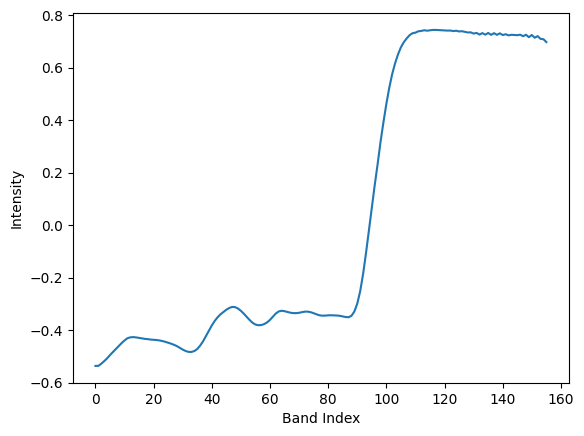

In [233]:
# Select the pixel of interest
#x, y = 10, 20

# Extract the spectral signature of the pixel
pixel_spectrum = Centers[0,:]

# Plot the spectral signature
plt.plot(pixel_spectrum)
plt.xlabel('Band Index')
plt.ylabel('Intensity')
#plt.title('Spectral Signature of Pixel at ({}, {})'.format(x, y))
plt.show()


In [234]:
# For each cluster, find the closest pixel to the center of the cluster

# For each pixel if its lable is '3' it has to go to the cluster with index '3'

Clust_Dict={}
j=0
for i in data:
  k=Lables[j]
  if(str(k) not in Clust_Dict.keys()):
    Clust_Dict[str(k)]=i
    Clust_Dict[str(k)]=[Clust_Dict[str(k)]]
  else:
    Clust_Dict[str(k)].append(i)
  j=j+1
pie=0
for x,y in Clust_Dict.items():
  pie=pie+len(y)
  print(x,len(y))
print(pie)

k=[]
for i in Lables:
  if i not in k:
    k.append(i)
print(k)


1 3186
2 4366
0 1473
9025
[1, 2, 0]


In [235]:
print(cluster_counts)

[1473 3186 4366]


Spectral Angular Distance, 

In [236]:
from sklearn.metrics.pairwise import cosine_similarity
def SADkp(y_true, y_pred):
    y_true = y_true.reshape(1, -1)
    y_pred = y_pred.reshape(1, -1)
    A = -cosine_similarity(y_true, y_pred)
    sad = np.arccos(A)
    return sad[0, 0]
    
def Ckp(x,y):
    val=1.0-SADkp(x,y)/np.pi
    return val

In [237]:
#Now after mapping each and every pixel into its respective labels
#spectral angular distance is to be found between each and every pixel and its centre
#after that the minimum distance pixels are considered to be our new endmember

# k is a list that contains labels in a spectific order
#EndMember_Dict is the final dictonary 
temp=0
temp_label=100000000
EndMember_Dict={}


In [238]:
#creating a list of labels 
k=[]
for i in Lables:
  if i not in k:
    k.append(i)
    print(type(i))
print(k)

<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
[1, 2, 0]


In [239]:
for i in range(0,end_mem):
  pi=[]
  temp_k=k[i]
  Temp_Clust_Dict_Value=Clust_Dict[str(temp_k)]
  for j in Temp_Clust_Dict_Value:
    temp=Ckp(Centers[i], j)
    #temp = Ckp(tf.cast(Centers[i], tf.float32), tf.cast(j, tf.float32))
    temp1 = tf.get_static_value(temp).astype(np.uint16)
    if(i==0):
      temp_label=temp1
    if(i>0):
      if(temp1<temp_label):
        temp_label=temp1
        pi=j
  if(len(pi)==0):
    pi=j
  EndMember_Dict[str(k[i])]=pi

In [240]:
#Converting the endmember signatures into a list 
EndMember_List=[]

for i in EndMember_Dict.values():
  EndMember_List.append(i)

for i in EndMember_List:
  print(len(i))

156
156
156


# HSI class

In [241]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

EPS=1e-6

class HSI:
    def __init__(
        self,
        name: str,
        data_dir: str = "./",
    ):
        path = os.path.join(data_dir, name)
        assert os.path.isfile(path)
        self.shortname = name.strip(".mat")

        data = sio.loadmat(path)
        print(f"Matlab data keys: {data.keys()}")

        for key in filter(
            lambda k: not k.startswith("__"),
            data.keys(),
        ):
            self.__setattr__(key, data[key])

        # Data format check
        self.H = self.H.item()
        self.W = self.W.item()
        self.L = self.L.item()
        self.p = self.p.item()

        self.N = self.H * self.W

        assert self.E.shape == (self.L, self.p)
        assert self.Y.shape == (self.L, self.N)

        # Data normalization
        self.Y = (self.Y - self.Y.min()) / (self.Y.max() - self.Y.min())

        try:
            assert len(self.labels) == self.p
            # Curate labels from MATLAB string formatting
            tmp_labels = list(self.labels)
            self.labels = [s.strip(" ") for s in tmp_labels]

        except AssertionError:
            # Create pseudo labels
            self.labels = [f"#{ii}" for ii in range(self.p)]

        assert self.A.shape == (self.p, self.N)
        # Abundance Sum to One Constraint (ASC)
        assert np.allclose(self.A.sum(0), np.ones(self.N))
        # Abundance Non-negative Constraint (ANC)
        assert np.all(self.A >= -EPS)
        # Endmembers Non-negative Constraint
        self.E = np.maximum(self.E, 0)
        assert np.all(self.E >= -EPS)

    def __repr__(self):
        msg = f"HSI => {self.shortname}\n"
        msg += "---------------------\n"
        msg += f"{self.L} bands,\n"
        msg += f"{self.H} lines, {self.W} samples, ({self.N} pixels),\n"
        msg += f"{self.p} endmembers ({self.labels})\n"
        msg += f"GlobalMinValue: {self.Y.min()}, GlobalMaxValue: {self.Y.max()}\n"
        return msg

    def __call__(self):
        Y = np.copy(self.Y)
        E = np.copy(self.E)
        A = np.copy(self.A)
        return (Y, E, A)

    def plot_endmembers(
        self,
        E0=None,
    ):
        """
        Display endmembers spectrum signature
        """
        # Plot attributes
        title = f"{self.shortname}"
        ylabel = "Reflectance"
        xlabel = "# Bands"
        if E0 is None:
            E = np.copy(self.E)
            title += " GT Endmembers\n"
            linestyle = "-"
        else:
            assert self.E.shape == E0.shape
            E = np.copy(E0)
            title += " Estimated Endmembers\n"
            linestyle = "--"
        # Figure
        plt.figure(figsize=(6, 6))
        for pp in range(self.p):
            data = E[:, pp]
            plt.plot(data, label=self.labels[pp], linestyle=linestyle)
        plt.title(title)
        plt.legend(frameon=True)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def plot_abundances(
        self,
        A0=None,
        transpose=False,
    ):
        """
        Display abundances maps
        """
        nrows, ncols = (1, self.p)
        title = f"{self.shortname}"
        if A0 is None:
            A = np.copy(self.A)
            title += " GT Abundances"
        else:
            assert self.A.shape == A0.shape
            A = np.copy(A0)
            title += " Estimated Abundances"
        A = A.reshape(self.p, self.H, self.W)

        if transpose:
            A = A.transpose(0, 2, 1)

        fig, ax = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(12, 4 * nrows),
        )
        kk = 0
        for ii in range(nrows):
            for jj in range(ncols):
                if nrows == 1:
                    curr_ax = ax[jj]
                else:
                    curr_ax = ax[ii, jj]
                mappable = curr_ax.imshow(
                    A[kk, :, :],
                    vmin=0.0,
                    vmax=1.0,
                )
                curr_ax.set_title(f"{self.labels[kk]}")
                curr_ax.axis("off")
                fig.colorbar(
                    mappable,
                    ax=curr_ax,
                    shrink=0.5,
                )
                kk += 1

                if kk == self.p:
                    break

        plt.suptitle(title)
        plt.show()

## Method SAD

In [242]:
def SAD(y_true, y_pred):
    A = -tf.keras.losses.cosine_similarity(y_true,y_pred)
    sad = tf.math.acos(A)
    return sad

## Method C
method that implements 
$$C(x^{(i)},x^{(j)})=1.0-\frac{SAD(x^{(i)},x^{(j)})}{\pi}$$

In [243]:
def C(x,y):
    val=1.0-SAD(x,y)/np.pi
    return val

In [244]:
class Cdot(object):
    def __init__(self,vec):
        self.vec=vec
        
    def dot(self, x):
        val=1.0-SAD(self.vec,x)/np.pi
        return val

## Fidelity terms
The fidelity terms of the loss
$$\mathcal{L} = \frac{\lambda_0}{2}\|\mathbf{x}-\hat{\mathbf{x}}\|_2^2-\lambda_1 D_\text{KL}(1.0||C(\mathbf{x},\hat{\mathbf{x}}))$$


In [245]:
class Endnet_loss(object):
    def __init__(self, batch_size,lambda0,lambda1):
        self.lambda0 = lambda0
        self.lambda1 = lambda1
        self.b = batch_size
    def loss(self, y_true, y_pred):
        MSE = tf.keras.losses.mse(y_true,y_pred) 
        c=C(y_true,y_pred)
        KL_Divergence = -tf.math.log(c)
        loss = self.lambda0/2.0*MSE+self.lambda1*KL_Divergence
        return loss

## Class SumToOne
Custom layer that enforces the ASC. Also performs regularizations l1
$$\lambda_2\|\mathbf{z}\|_1$$

In [246]:
class SumToOne(layers.Layer):
    def __init__(self, params, **kwargs):
        super(SumToOne, self).__init__(**kwargs)
        self.params = params
    
    def mask_all_but_top_k(self,X, k):
        n = X.shape[1]
        top_k_indices = tf.math.top_k(X, k).indices
        mask = tf.reduce_sum(tf.one_hot(top_k_indices, n), axis=1)
        return mask * X
    
    def l1_regularization(self,x):
        l1 = regularizers.l1(1.0)(x)
        return self.params['lambda2'] * l1
        
    def call(self, x):
        self.add_loss(self.l1_regularization(x))
        x = self.mask_all_but_top_k(x,2)
        x = tf.abs(x)/(tf.reduce_sum(x, axis=-1, keepdims=True)+K.epsilon())
        return x

## Class MaskedNoise
Adds noise to the layer masked


In [247]:
class MaskedNoise(layers.Layer):
    def __init__(self, params, **kwargs):
        super(MaskedNoise, self).__init__(**kwargs)
        self.std = params['noise']
    
        
    def call(self, x, training=None):
        if training:
            mask = tf.nn.dropout(tf.ones_like(x),0.4)
            noise = layers.GaussianNoise(self.std)(tf.zeros_like(x))
            return x+mask*noise
        else:
            return x

## Class Spectral_BN
Performs batch normalization with no scaling
$$BN(\bf{h})=\frac{\bf{h}-\bf{\mu}}{\sqrt{\bf{\sigma^2}+\epsilon}}+\bf{\rho}$$

In [248]:
class Spectral_BN(layers.Layer):
    def __init__(self, params, **kwargs):
        super(Spectral_BN, self).__init__(**kwargs)
        self.num_outputs = params['num_endmembers']
        self.params = params
    
    def l2_regularization(self,x):
        l2 = tf.reduce_sum(tf.square(x))
        return self.params['lambda5'] * l2
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.p = self.add_weight(shape=(input_dim,),
                                 initializer="zeros",
                                 trainable=True)
    def call(self, x, training=None):
        if training is not None:
            mu = tf.reduce_mean(x,axis=0)
            sigma = tf.sqrt(tf.math.reduce_variance(x,axis=0)+K.epsilon())
            y = (x-mu)/sigma+self.p
            self.add_loss(self.l2_regularization(self.p))
            return y
        else:
            return x

In [249]:
class SparseReLU(tf.keras.layers.Layer):
    def __init__(self):
        super(SparseReLU, self).__init__()
    def build(self, input_shape):
        self.alpha = self.add_weight(shape=input_shape[1:],initializer=tf.keras.initializers.Zeros(),
        trainable=True, constraint=tf.keras.constraints.non_neg())
        super(SparseReLU, self).build(input_shape)
    def call(self, x):
        return tf.keras.backend.relu(x - self.alpha)

## Class Custom_layer_transform
Performs matrix vector multiplication using custom innner product

In [250]:
class Custom_layer_transform(object):
    def __init__(self,W:tf.Tensor):
        self.W = tf.transpose(W)
    def custom_matvec_prod(self, a:tf.Tensor):
        cdot = Cdot(a)
        return tf.map_fn(cdot.dot,self.W)
    
    def transform(self,Batch:tf.Tensor):
        return tf.map_fn(self.custom_matvec_prod, Batch)
        #return tf.transpose(tf.map_fn(self.custom_matvec_prod, Batch),(0,2,1))
    

## Class SAD_Layer
This is a dense layer that transforms its inputs using a custom matrix vector product that uses normalized SAD as the inner product.

In [251]:
class SAD_Layer(tf.keras.layers.Layer):
    def __init__(
        self,
        units,
        activation=None,
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        **kwargs
    ):
        if "input_shape" not in kwargs and "input_dim" in kwargs:
            kwargs["input_shape"] = (kwargs.pop("input_dim"),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
        self.activity_regularizer = tf.keras.regularizers.get(activity_regularizer)
        self.kernel_constraint = tf.keras.constraints.get(kernel_constraint)
        self.bias_constraint = tf.keras.constraints.get(bias_constraint)
        self.input_spec = tf.keras.layers.InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(
            shape=(input_dim, self.units),
            initializer=self.kernel_initializer,
            name="kernel",
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            )
        if self.use_bias:
                self.bias = self.add_weight(
                    shape=(self.units,),
                    initializer=self.bias_initializer,
                    name="bias",
                    regularizer=self.bias_regularizer,
                    constraint=self.bias_constraint,
                    )
        else:
            self.bias = None
        self.input_spec = tf.keras.layers.InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        print(self.kernel.get_shape())
        print(inputs.get_shape())
        custom_transform = Custom_layer_transform(self.kernel)
        output = custom_transform.transform(inputs)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format="channels_last")
        if self.activation is not None:
            output = self.activation(output)
        return output

## Class Autoencoder
Wrapper class for the autoencoder model and associcated utility functions

In [252]:
class Autoencoder(object):
    def __init__(self, params,W=None):
        #self.data = params["data"].array()
        self.data = params["data"]
        self.params = params
        self.masked_noise = MaskedNoise(params)
        self.decoder = layers.Dense(
            units=self.params["n_bands"],
            kernel_regularizer=regularizers.l2(self.params['lambda4']),
            activation='linear',
            name="output",
            kernel_constraint=constraints.non_neg(),
            use_bias=False)
            
        self.hidden = SAD_Layer(
            units=self.params["num_endmembers"],
            activation='linear',
            kernel_regularizer=regularizers.l2(self.params['lambda3']),
            name='hidden',
            use_bias=False
        )

        #self.spectral_bn = Spectral_BN(params)# BatchNormalization(scale=False)
        self.sparse_relu = SparseReLU()
        self.asc_layer = SumToOne(self.params, name='abundances')
        self.model = self.create_model()
        self.model.compile(optimizer=self.params["optimizer"], loss=self.params["loss"])
        #self.initalize_encoder_and_decoder(W)

    def initalize_encoder_and_decoder(self,W):
        if W is None: return
        self.model.get_layer('output').set_weights([W.T])
        self.model.get_layer('hidden').set_weights([W])
        return
        
        
    def create_model(self):
        input_features = layers.Input(shape=(self.params["n_bands"],))
        code = self.masked_noise(input_features)
        code = self.hidden(code)
        code = layers.BatchNormalization(scale=False)(code)
        #code = self.spectral_bn(code)
        code = layers.Dropout(self.params['p'])(code)
        code = tf.keras.activations.relu(code)
        abunds = self.asc_layer(code)
        output = self.decoder(abunds)

        return tf.keras.Model(inputs=input_features, outputs=output)
    
    def fix_decoder(self):
        for l in self.model.layers:
            l.trainable = True
        self.model.layers[-1].trainable = False
        self.decoder.trainable = False
        self.model.compile(optimizer=self.params["optimizer"], loss=self.params["loss"])

    def fix_encoder(self):
        for l in self.model.layers:
            l.trainable = True
        self.model.get_layer('hidden').trainable = False
        self.hidden.trainable = False
        self.model.compile(optimizer=self.params["optimizer"], loss=self.params["loss"])

        
    
    def fit(self,data,n):
        #plot_callback = PlotWhileTraining(n,self.params['data'])
        return self.model.fit(
            x=data,
            y=data,
            batch_size=self.params["batch_size"],
            epochs=self.params["epochs"],
        )
    
    def train_alternating(self,data,epochs):
        for epoch in range(epochs):
            self.fix_decoder()
            self.model.fit(x=data, y=data,
                batch_size=self.params["batch_size"],
                epochs=2)
            self.fix_encoder()
            self.model.fit(x=data, y=data,
                batch_size=self.params["batch_size"],
                epochs=1)
            #if epoch % 3 == 0:
            #    endmembers = self.get_endmembers()
            #    abundances = self.get_abundances()
            #    plotEndmembersAndGT(endmembers,self.params['data'].gt)
            #    plotAbundancesSimple(abundances,'abunds')

    def get_endmembers(self):
        #one_hot = tf.one_hot(tf.range(0,self.params['num_endmembers']),self.params['num_endmembers'])
        return self.model.layers[len(self.model.layers) - 1].get_weights()[0]

    def get_abundances(self):
        intermediate_layer_model = tf.keras.Model(
            inputs=self.model.input, outputs=self.model.get_layer("abundances").output
        )
        abundances = intermediate_layer_model.predict(self.data)
        #abundances = np.reshape(abundances,[self.params['data'].cols,self.params['data'].rows,self.params['num_endmembers']])
        

        return abundances

Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'])
HSI => Samson
---------------------
156 bands,
95 lines, 95 samples, (9025 pixels),
3 endmembers (['soil', 'tree', 'water'])
GlobalMinValue: 0.0, GlobalMaxValue: 1.0



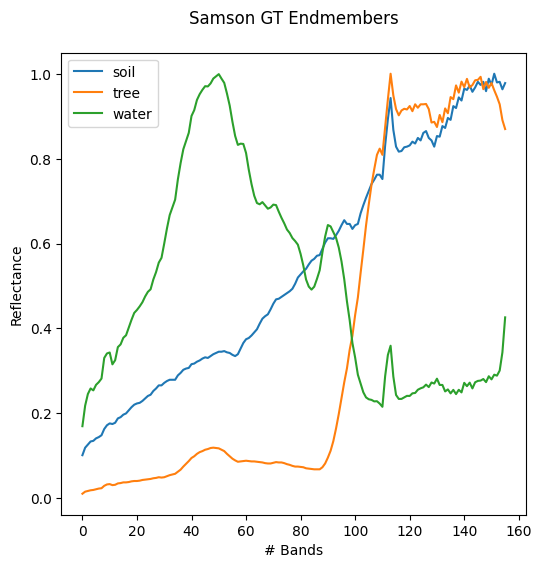

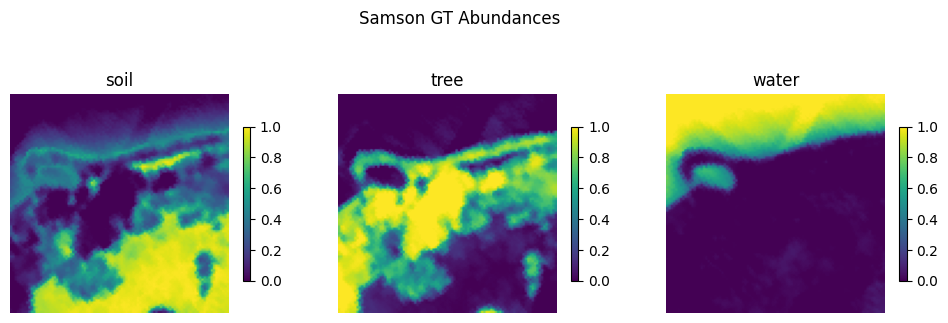

In [253]:

'''
first of all let us understand the datasets we have
  1. TinyAPEX
  2. JasperRidge
  3. Samson
  4. DC2
  5. Sim1
'''
#change is to be done here

# hsi = HSI("TinyAPEX.mat")
# print(hsi)
# hsi.plot_endmembers()
# hsi.plot_abundances()

# hsi=HSI("JasperRidge.mat")
# print(hsi)
# hsi.plot_endmembers()
# hsi.plot_abundances()

hsi=HSI("Samson.mat")
print(hsi)
hsi.plot_endmembers()
hsi.plot_abundances()

# hsi=HSI("DC2.mat")
# print(hsi)
# hsi.plot_endmembers()
# hsi.plot_abundances()

# hsi=HSI("Sim1.mat")
# print(hsi)
# hsi.plot_endmembers()
# hsi.plot_abundances()

In [254]:
# Hyperparameters

#let us first work on tinyapex and then go with other datasets

num_endmembers = hsi.p
print(num_endmembers)
num_spectra = 4000
batch_size = 64
learning_rate = 0.001
epochs = 40
#epochs = 5
lambda0 = 0.01
lambda1 = 50.0
lambda2 = 0.0
lambda3 = 1e-5
lambda4 = 1e-5
lambda5 = 1e-3
p = 0.1
noise_std = 0.3
opt = tf.optimizers.legacy.Adam(learning_rate=learning_rate,beta_1=0.7)

'''https://stackoverflow.com/questions/75356826/attributeerror-adam-object-has-no-attribute-get-updates'''


noise = AWGN()

SNR = 40

hsi.Y = noise.fit_transform(hsi.Y, SNR=SNR, seed=0)



data, GT, _ = hsi()

# Reshape data
data = data.T

# Hyperparameter dictionary
params = {
    "lambda0":lambda0,
    "lambda1":lambda1,
    "lambda2":lambda2,
    "lambda3":lambda3,
    "lambda4":lambda4,
    "lambda5":lambda5,
    "p":p,
    "num_endmembers": num_endmembers,
    "batch_size": batch_size,
    "num_spectra": num_spectra,
    "data": data,
    "epochs": epochs,
    "n_bands": hsi.L,
    #"GT": hsi.gt,
    "GT": GT,
    "lr": learning_rate,
    "optimizer": opt,
    "noise":noise_std,
    "loss":Endnet_loss(batch_size,lambda0,lambda1).loss
}

plot_every = 0 #Plot endmembers and abundance maps every x epochs. Set to 0 when running experiments. 

training_data = data[
    np.random.randint(0, data.shape[0], num_spectra), :
]

3
Y shape: (156, 9025)
Desired SNR: 40
Sigmas after normalization: 0.08006407690254357
Sigma mean based on SNR: 0.03051588142113546
Final sigmas value: 0.00244322587685069


In [255]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [256]:
init=np.transpose(EndMember_List, axes=None)
print(init.shape)
print(len(init))
print(type(init))
print(init.ndim)
print(init.size)
print(init.dtype)
print(init.itemsize)



(156, 3)
156
<class 'numpy.ndarray'>
2
468
float64
8


In [257]:
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import initializers, constraints, layers, activations, regularizers
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import tensor_shape

In [258]:
autoencoder = Autoencoder(params,init)
autoencoder.fit(training_data,plot_every)
endmembers = autoencoder.get_endmembers()
abundances = autoencoder.get_abundances()


(156, 3)
(None, 156)
Train on 4000 samples
Epoch 1/40
4000/4000 [==============================] - 7s 2ms/sample - loss: 18.6883
Epoch 2/40
4000/4000 [==============================] - 7s 2ms/sample - loss: 11.7939
Epoch 3/40
4000/4000 [==============================] - 9s 2ms/sample - loss: 5.2197
Epoch 4/40
4000/4000 [==============================] - 9s 2ms/sample - loss: 3.2971
Epoch 5/40
4000/4000 [==============================] - 7s 2ms/sample - loss: 3.1757
Epoch 6/40
4000/4000 [==============================] - 8s 2ms/sample - loss: 3.4379
Epoch 7/40
4000/4000 [==============================] - 7s 2ms/sample - loss: 3.0924
Epoch 8/40
4000/4000 [==============================] - 5s 1ms/sample - loss: 3.2573
Epoch 9/40
4000/4000 [==============================] - 3s 741us/sample - loss: 3.1318
Epoch 10/40
4000/4000 [==============================] - 3s 722us/sample - loss: 2.8151
Epoch 11/40
4000/4000 [==============================] - 3s 739us/sample - loss: 2.9295
Epoch 12/40


/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## Qualitative results

---

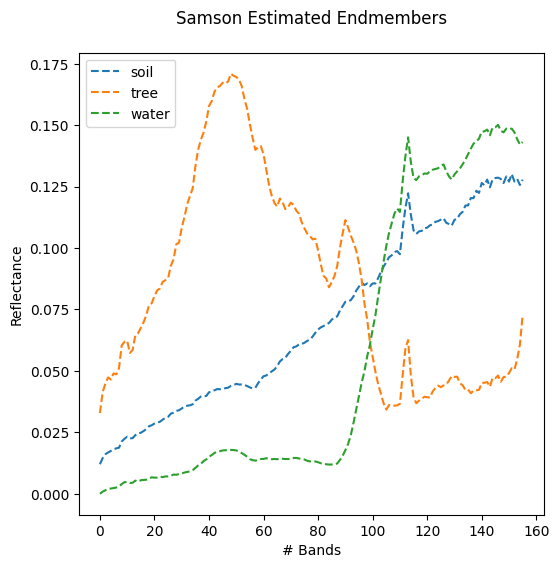

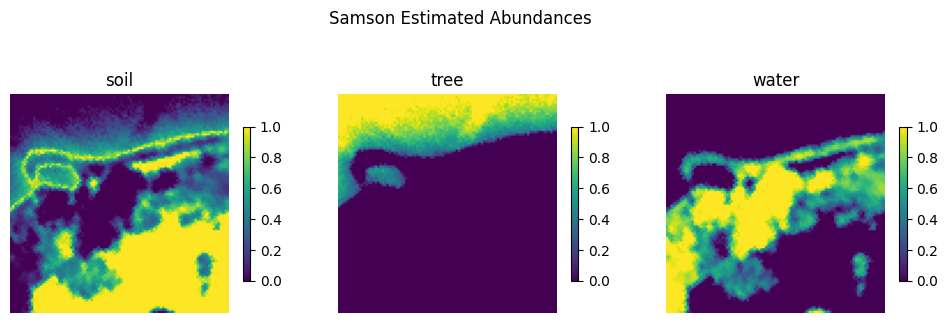

In [259]:
E0 = endmembers.T
A0 = abundances.T

# Plot results
hsi.plot_endmembers(E0=E0)
hsi.plot_abundances(A0=A0)

## Endmembers alignment

---

At this stage we need to align the endmembers and the abundances to compute the RMSE and SAD metrics.


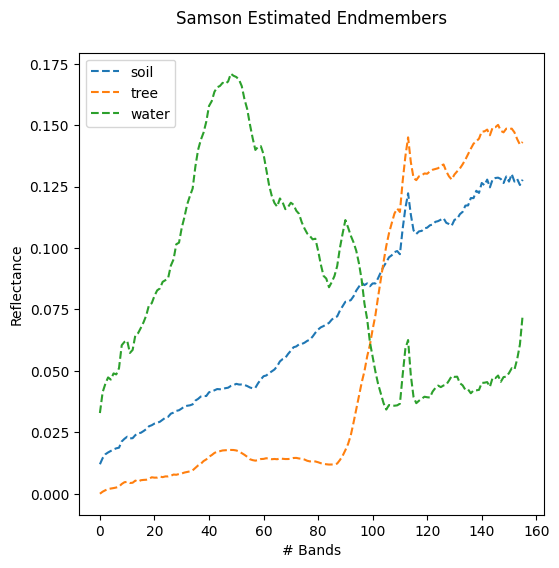

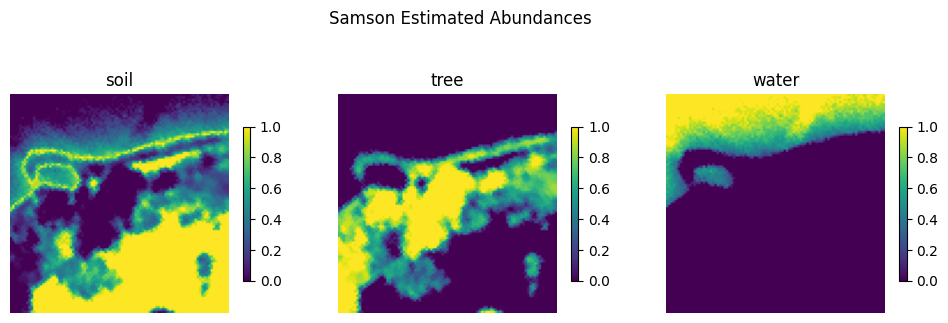

In [260]:
# Select a criterion to perform alignment
criterion = MSE()

# Select an aligner to perform alignment
aligner = Aligner(hsi=hsi, criterion=criterion)

A1 = aligner.fit_transform(A0)
E1 = aligner.transform_endmembers(E0)

# Plot alignment
hsi.plot_endmembers(E0=E1)
hsi.plot_abundances(A0=A1)

## Quantitative results

---

We are now in shape to compute the abundances RMSE and endmembers SAD.

In [261]:
# Instantiate metrics
rmse = RMSE()
sad = SADMetric()
sre = SRE()

# Compute final numbers
print(f"RMSE => {rmse(hsi.A, A1):.2f}")
print(f"SAD => {sad(hsi.E, E1):.2f}")
print(f"SRE => {sre(A1, hsi.A):.2f}")

RMSE => 10.10
SAD => 1.47
SRE => 13.93


### Results for each material

In [262]:
# Change the following line if you change dataset!
# Either comment out or describe each material name.

#change is to be done here

# hsi.labels = ['#0','#1','#2','#3']  # for TinyAPEX
# hsi.labels = ['tree','water','dirt','road'] # for JasperRidge
hsi.labels = ['soil','tree','water'] # for Samson
# hsi.labels = ['#0','#1','#2','#3','#4','#5','#6','#7','#8'] # for DC2
# hsi.labels = ['#0','#1','#2','#3','#4','#5'] # for Sim1
assert len(hsi.labels) == hsi.p

for ii, label in enumerate(hsi.labels):
    a, ahat = hsi.A[ii], A1[ii]
    print(f"RMSE ({label}) => {rmse(a, ahat):.2f}")

print("-" * 15)

for ii, label in enumerate(hsi.labels):
    e, ehat = hsi.E[:, ii][:, None], E1[:, ii][:, None]
    print(f"SAD ({label}) => {sad(e, ehat):.2f}")

RMSE (soil) => 13.27
RMSE (tree) => 9.30
RMSE (water) => 6.57
---------------
SAD (soil) => 0.72
SAD (tree) => 2.25
SAD (water) => 1.45
